## Exploring France's Jewellery imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United NationS Comtrade database provides data on global trade. It will be used to analyse the France's imports and exports of jewellery in 2019:

* How much does France export and import and is the balance positive (more exports than imports)?
* Which are the main trading partners, i.e. from/to which countries does France import/export the most?
* Which are the regular customers, i.e. which countries buy jewellery from France every month?
* Which countries does France both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data
The data is obtained from the United Nations Comtrade website, by selecting the following configuration:

* Type of Product: goods
* Frequency: monthly
* Periods: April to August of 2019
* Reporter: France
* Partners: all
* Flows: imports and exports
* HS (as reported) commodity codes: 711311 (Jewellery; of silver, whether or not plated or clad with other precious metal, and parts thereof) and 711319 (Jewellery; of precious metal (excluding silver) whether or not plated or clad with precious metal, and parts thereof)


Data was downloaded using the Download CSV button and the download file renamed appropriately.

In [2]:
LOCATION = 'comtrade_jewellery_fr_apr_aug_19.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

* max=500 is increased to max=5000 to make sure all data is loaded,
* reporter code for france=251
* commodity codes to 711311 and 711319 respectively
* &fmt=csv is added at the end to obtain the data in CSV format.

In [3]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201908%2C201907%2C201906%2C201905%2C201904&r=251&p=all&rg=1%2C2&cc=711311%2C711319&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero

In [4]:
jewellery = read_csv(LOCATION, dtype={'Commodity Code':str})
jewellery.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
1263,HS,2019,201904,April 2019,6,1,2,Exports,251,France,...,NaN,NaN,NaN,NaN,0.0,NaN,27464,NaN,NaN,0
1264,HS,2019,201904,April 2019,6,1,2,Exports,251,France,...,NaN,NaN,NaN,NaN,0.0,NaN,2875,NaN,NaN,0


The data only covers the five months of 2019 (April to August). Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [5]:
def jewelleryType(code):
    if code == '711311': # silver
        return 'valuable'
    if code == '711319': # precious metal excluding silver
        return 'more valuable' 
    return 'unknown'

COMMODITY = 'Jewellery'
jewellery[COMMODITY] = jewellery['Commodity Code'].apply(jewelleryType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
jewellery = jewellery[headings]
jewellery.head()

,Period,Partner,Trade Flow,Jewellery,Trade Value (US$)
0,201908,Czech Rep.,Exports,valuable,77969
1,201904,Canada,Exports,valuable,32726
2,201904,Bulgaria,Exports,valuable,16261
3,201907,Chile,Exports,valuable,188
4,201904,Czech Rep.,Exports,valuable,44960


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [6]:
jewellery = jewellery[jewellery[PARTNER] != 'World']
jewellery.head()

,Period,Partner,Trade Flow,Jewellery,Trade Value (US$)
0,201908,Czech Rep.,Exports,valuable,77969
1,201904,Canada,Exports,valuable,32726
2,201904,Bulgaria,Exports,valuable,16261
3,201907,Chile,Exports,valuable,188
4,201904,Czech Rep.,Exports,valuable,44960


## Total trade flow
To answer the first question, 'how much does France export and import and is the balance positive (more exports than imports)?', the dataframe is split into two groups: exports from France and imports into France. The trade values within each group are summed up to get the total trading.

In [7]:
grouped = jewellery.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    3321703089
Imports    3042549553
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 270 million dollars.

## Main trade partners
To address the second question, 'Which are the main trading partners, i.e. from/to which countries does France import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [8]:
imports = jewellery[jewellery[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('France imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to France are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

France imports from 88 countries.
The 5 biggest exporters to France are:


Partner
Areas, nes        1009611227
Switzerland        627711093
United Kingdom     500462884
France             388060010
Italy              192207044
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

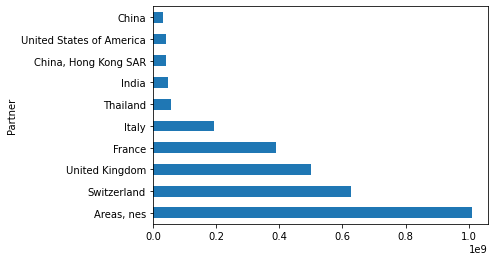

In [9]:
totalImports.head(10).plot(kind='barh')

In [10]:
exports = jewellery[jewellery[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('France exports to', len(grouped), 'countries.')
print('The 5 biggest importers from France are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

France exports to 105 countries.
The 5 biggest importers from France are:


Partner
Switzerland             1276025589
United Kingdom          1142316368
Italy                    229191070
China, Hong Kong SAR     156421055
Germany                   74801555
Name: Trade Value (US$), dtype: int64

## Regular importers
Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy jewellery from France every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [14]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201904) & (regular[COMMODITY] == 'more valuable')]

,Period,Partner,Trade Flow,Jewellery,Trade Value (US$)
22,201904,Canada,Exports,more valuable,626167
23,201904,Bulgaria,Exports,more valuable,373090
24,201904,Czech Rep.,Exports,more valuable,538228
26,201904,Spain,Exports,more valuable,4798971
80,201904,Sweden,Exports,more valuable,1626693
130,201904,"Areas, nes",Exports,more valuable,20658
194,201904,Romania,Exports,more valuable,607
204,201904,Luxembourg,Exports,more valuable,453339
206,201904,Singapore,Exports,more valuable,5735556
211,201904,Latvia,Exports,more valuable,3015


In [17]:
#def buysEveryMonth(group):
    #return len(group) == 10

#grouped = exports.groupby([PARTNER])
#regular = grouped.filter(buysEveryMonth)
#regular[(regular[MONTH] == 201908) & (regular[COMMODITY] == 'more valuable')]

Just over 99% of the total UK exports are due to these regular customers.

In [18]:
regular[VALUE].sum() / exports[VALUE].sum()

0.9901464700116067

## Bi-directional trade
To address the fourth question, 'Which countries does France both import from and export to?', a pivot table is used to list the total export and import value for each country.

In [19]:
countries = pivot_table(jewellery, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,NaN,2.080000e+03
Algeria,35106.0,1.140000e+02
Andorra,589238.0,1.831000e+03
"Areas, nes",165875.0,1.009611e+09
Argentina,NaN,4.310000e+03


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with France.

In [20]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Algeria,3.510600e+04,1.140000e+02
Andorra,5.892380e+05,1.831000e+03
"Areas, nes",1.658750e+05,1.009611e+09
Armenia,1.569600e+04,7.060000e+02
Australia,3.749672e+06,5.649700e+04
...,...,...
Ukraine,1.391960e+05,1.914000e+03
United Arab Emirates,2.498767e+07,4.318258e+06
United Kingdom,1.142316e+09,5.004629e+08


## Conclusions
The jewellery trade of France from April to August 2019 was analysed in terms of which countries France mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 270 million US dollars.

Areas, nes is the main partner, but it imported from France a million times the  value it exported to France.

France exported to over 105 countries during the period, but only imported from 88 countries, the main ones (top five by trade value) being geographically close. China and Germany are the main importers that are not also main exporters.

France is heavily dependent on its regular customers, the 49 countries that buy all types of jewellery every month. They contribute three quarters of the total export value.

France has bi-directional trade (i.e. both exports and imports) with 85 countries.